The goal is to build a RNN model using PyTorch. The dataset consists of records from the Federal Reserve Economic Database (FRED) concerning Electricity and Gas Utilities Production from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/IPG2211A2N

In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# load the dataset
df = pd.read_csv('./Energy_Production.csv',index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.head()

325


,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


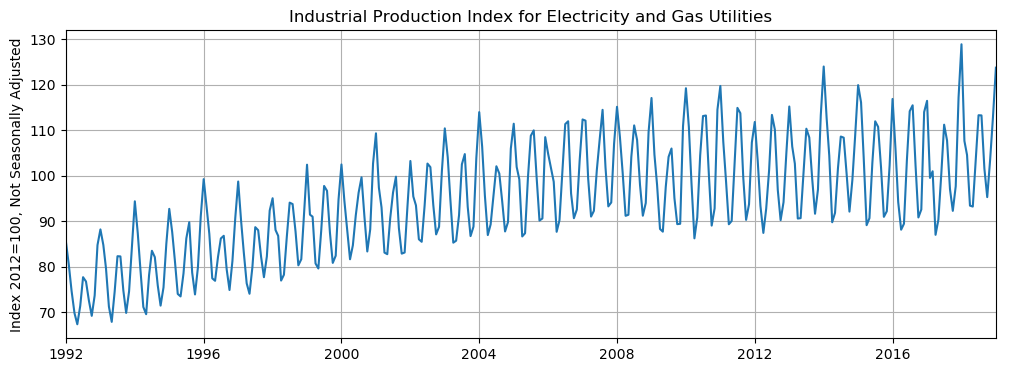

In [3]:
# plot the dataset
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

In [4]:
# split into train and test sets
y = df['IPG2211A2N'].values.astype(float)

test_size = 12
window_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 313
Test:  12


In [5]:
# normalize the train set
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

print(f'First item, original: {train_set[0]}')
print(f'First item, scaled: {train_norm[0]}')

First item, original: 85.556
First item, scaled: [-0.4091274]


In [6]:
# prepare the list of windowed sequence/label tuples to be fed into an LSTM model
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [7]:
train_data = input_data(train_norm,window_size)

print(f'Train_data: {len(train_data)}')

Train_data: 301


In [8]:
# define the model
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=64,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # initialize hidden state and cell state:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [9]:
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [10]:
# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
# train the model
import time
start_time = time.time()

epochs = 50

for i in range(epochs):
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        # apply the model
        y_pred = model(seq)

        # update parameters
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f'{i+1} of {epochs} epochs completed')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

1 of 50 epochs completed
2 of 50 epochs completed
3 of 50 epochs completed
4 of 50 epochs completed
5 of 50 epochs completed
6 of 50 epochs completed
7 of 50 epochs completed
8 of 50 epochs completed
9 of 50 epochs completed
10 of 50 epochs completed
11 of 50 epochs completed
12 of 50 epochs completed
13 of 50 epochs completed
14 of 50 epochs completed
15 of 50 epochs completed
16 of 50 epochs completed
17 of 50 epochs completed
18 of 50 epochs completed
19 of 50 epochs completed
20 of 50 epochs completed
21 of 50 epochs completed
22 of 50 epochs completed
23 of 50 epochs completed
24 of 50 epochs completed
25 of 50 epochs completed
26 of 50 epochs completed
27 of 50 epochs completed
28 of 50 epochs completed
29 of 50 epochs completed
30 of 50 epochs completed
31 of 50 epochs completed
32 of 50 epochs completed
33 of 50 epochs completed
34 of 50 epochs completed
35 of 50 epochs completed
36 of 50 epochs completed
37 of 50 epochs completed
38 of 50 epochs completed
39 of 50 epochs compl

In [12]:
# evaluate the model
future = 12
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())
        
preds[window_size:]

[0.2995114028453827,
 -0.024304654449224472,
 -0.333514004945755,
 -0.24056629836559296,
 0.18738996982574463,
 0.43583109974861145,
 0.28525516390800476,
 -0.0986364334821701,
 -0.23537534475326538,
 -0.012408558279275894,
 0.5200750827789307,
 0.646328330039978]

In [13]:
# inverse transform the predicted values
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[107.35691855],
       [ 97.39487946],
       [ 87.88220839],
       [ 90.74169811],
       [103.90755873],
       [111.55072587],
       [106.91833249],
       [ 95.10809944],
       [ 90.90139521],
       [ 97.76085691],
       [114.14244988],
       [118.02656791]])

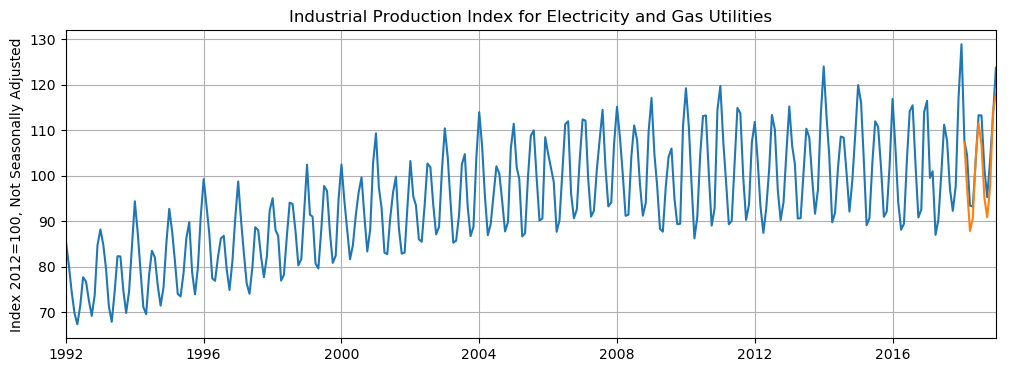

In [14]:
# plot the results
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions)
plt.show()

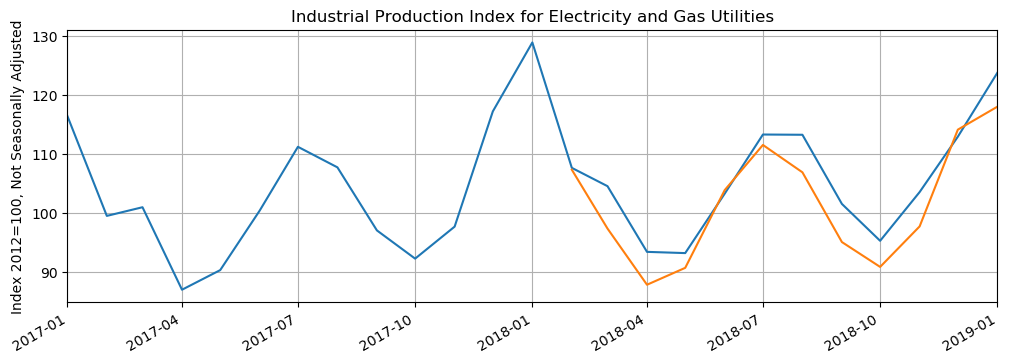

In [15]:
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()